# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# cargamos todas las librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict


In [2]:
# creamos el DataFrame 

df = pd.read_csv('/datasets/taxi.csv')


In [3]:
# mostramos una vista previa del DataFrame

df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [4]:
# mostramos la información general del DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# mostramos la información estadística del DataFrame, en específico de la columna 'num_orders'

df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
# cambiamos el tipo de la columna 'datetime', de object pasa a ser datetime

df['datetime'] =  pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f')

In [7]:
# indexamos la columna 'datetime'

df.set_index('datetime', inplace=True)

**Conclusiones Intermedias:**

1. Nos topamos con un DataFrame de dos columnas, donde no se visualizaron datos ausentes y duplicados.

2. Se cambio el tipo de la columna 'datetime' a formato de tiempo, ya que estaba en formato int64.



### Remuestreo

In [8]:
# mostramos una vista previa del DataFrame

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
# creamos el remuestreo 

df = df.resample('1H').sum().reset_index()

In [10]:
df.set_index('datetime', inplace = True)

In [11]:
# mostramos como quedo el DataFrame

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


### Procesos de Series

In [13]:
# creamos una función que determinara los procesos

def proce_serie(data, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    
proce_serie(df, 5, 10)

In [14]:
df.tail()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-08-31 19:00:00,136,8,31,19,4,207.0,217.0,197.0,116.0,133.0,173.3
2018-08-31 20:00:00,154,8,31,20,4,136.0,207.0,217.0,197.0,116.0,166.6
2018-08-31 21:00:00,159,8,31,21,4,154.0,136.0,207.0,217.0,197.0,162.9
2018-08-31 22:00:00,223,8,31,22,4,159.0,154.0,136.0,207.0,217.0,162.1
2018-08-31 23:00:00,205,8,31,23,4,223.0,159.0,154.0,136.0,207.0,170.8



## Análisis

In [15]:
# creamos un DataFrame sin las caraterísticas antes trabajadas

df_new = df[['num_orders']]

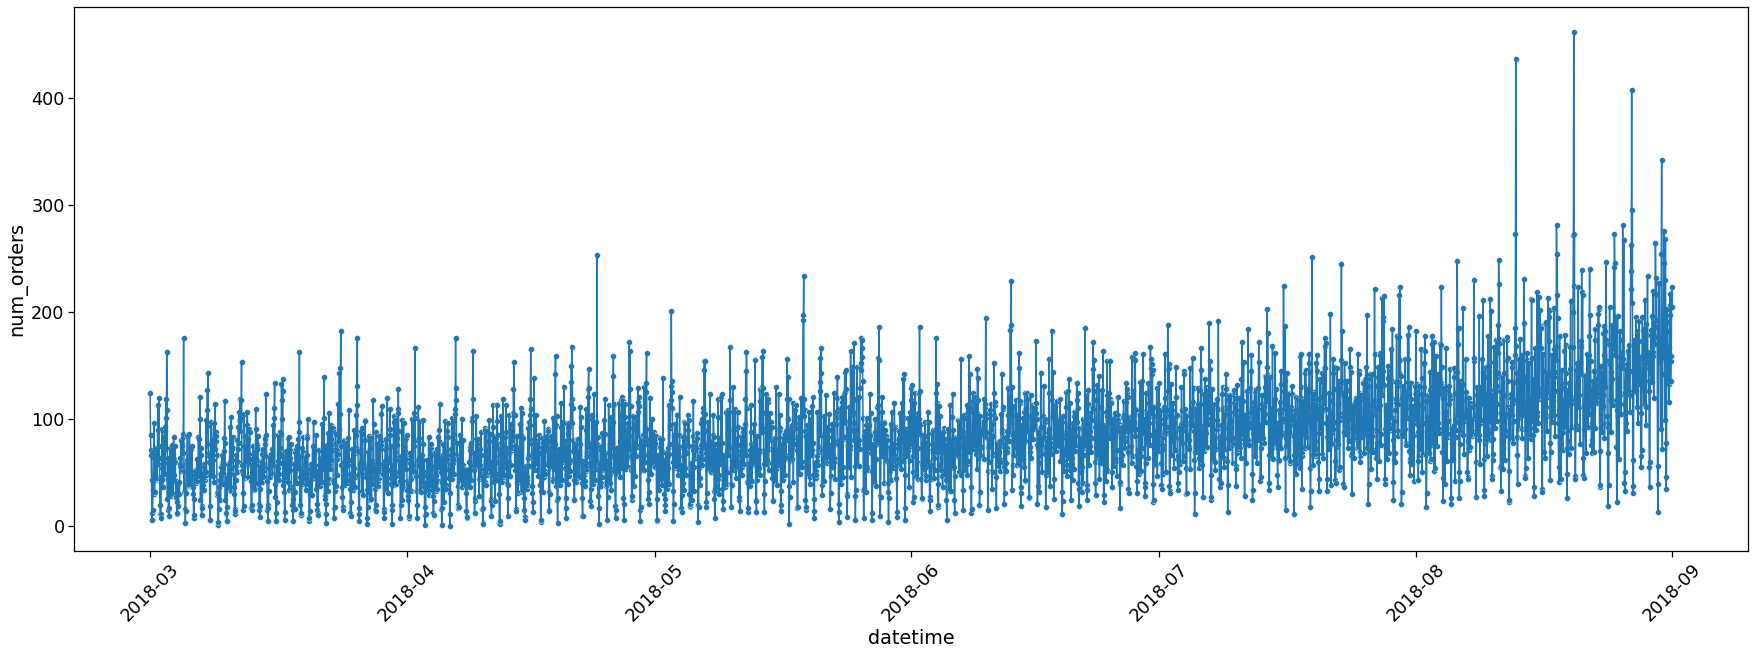

In [16]:
# creamos un gráfico de la distribución del número de ordenes de taxis

plt.figure(figsize = (30, 10))
sns.set_context(context = 'notebook', font_scale = 1.6)
sns.scatterplot(x = 'datetime', y = 'num_orders', data = df)
sns.lineplot(x = 'datetime', y = 'num_orders', data = df)
plt.xticks(rotation = 45)
plt.show()

**Conclusiones Intermedias:**

Podemos observar en la distribución que en los primeros meses sigue siendo la misma, con ligeros cambios a partir del mes 07 hasta 09. Podemos concluir que la distribución de los taxis no es estacionaria.

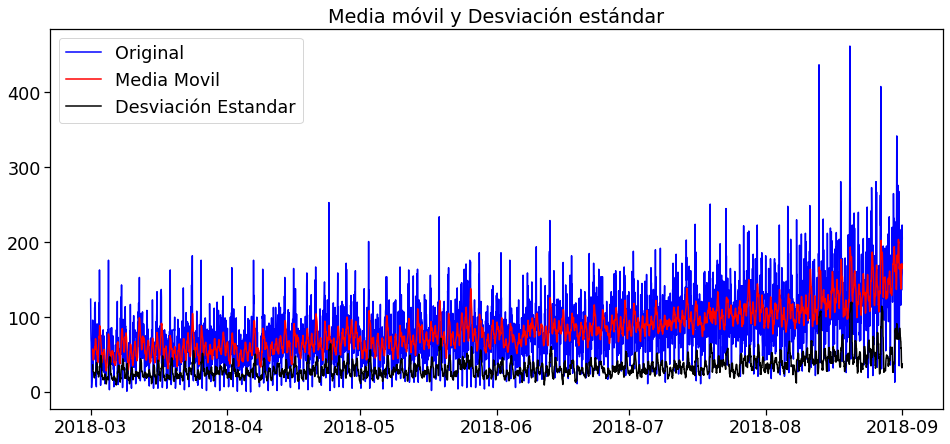

In [17]:
# creamos el gráfic de la desviación estandar y media

rollmean = df_new.rolling(12).mean()
rollstd = df_new.rolling(12).std()

plt.figure(figsize = (16, 7))
fig = plt.figure(1)

orig = plt.plot(df_new, color = 'blue', label = 'Original')
mean = plt.plot(rollmean, color = 'red', label = 'Media Movil')
std = plt.plot(rollstd, color = 'black', label = 'Desviación Estandar')
plt.legend(loc = 'best')
plt.title('Media móvil y Desviación estándar')
plt.show(block = False)

**Conclusiones Intermedias:**

Es complicado observar la tendencia de los datos, viendo que a partir del mes 07 hasta el mes 09 hay movimientos crecientes, lo cual se procedera a visualizar con el metodo de descomposicion estacional.


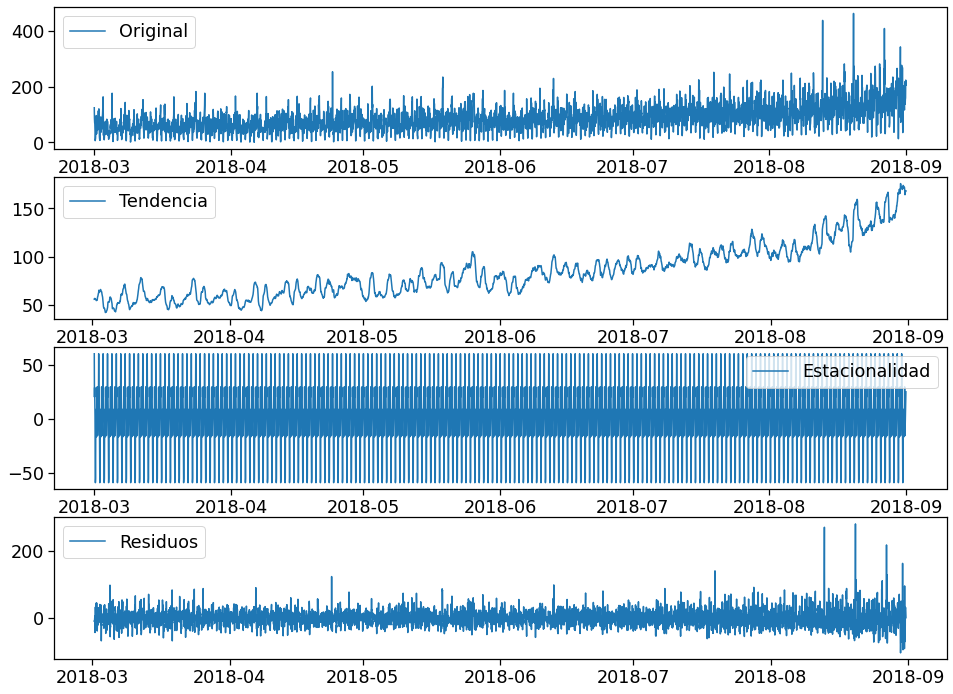

In [18]:
# creamos el gráfico de las tendencias y estacionalidad

decomposition = seasonal_decompose(df_new)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (16, 12))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(df_new, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendencia')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Estacionalidad')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuos')
plt.legend(loc = 'best')
plt.show()

**Conclusiones Intermedias:**

Con respecto al grafico de tendencia, podemos visualizar mejor que los movimientos son crecientes, pero muy pocos en los primeros meses, hasta que se llega al mes 07 que es notable el aumento. Con respecto al diagrama de residuos, se ven valores muy crecientes a partir del mes 08. Asimismo ocurre en el diagrama original.

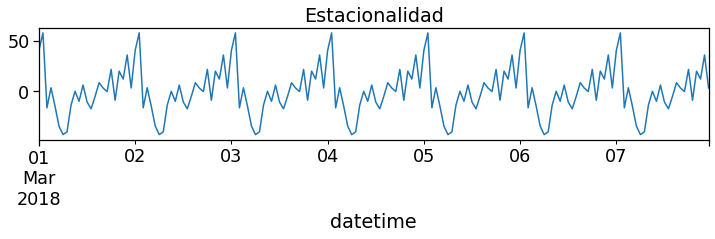

In [19]:
# creamos el remuestreo con la información de la estacionalidad en marzo

decomposed_resample = seasonal_decompose(df_new['2018-03-01':'2018-03-07'])

plt.figure(figsize = (12,7))
plt.subplot(312)
decomposed_resample.seasonal.plot(ax = plt.gca())
plt.title('Estacionalidad')
plt.show()

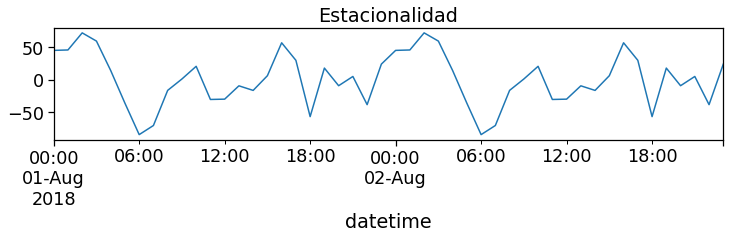

In [20]:
# creamos el remuestreo con la información de la estacionalidad en agosto

decomposed_resample = seasonal_decompose(df_new['2018-08-01':'2018-08-02'])

plt.figure(figsize = (12,7))
plt.subplot(312)
decomposed_resample.seasonal.plot(ax = plt.gca())
plt.title('Estacionalidad')
plt.show()

**Conclusiones Intermedias:**

En los graficos anteriores podemos ver que en el mes de marzo visualizamos desde el dia 01 hasta el dia 07, donde hay un pico y un decrecimiento notable, siendo un movimiento constante en estos dias. Mientras que en el segundo gráfico podemos ver que fueron dos dias estudiados, donde los picos expuestos son en la madrugada, empezando a las 12 de la noche. Asimismo se observa que el punto mas bajo, que es cuando no se contrata casi el servicio de reseva de los taxis es a las 6:00 am

## Formación

In [21]:
# creamos la división

train, test = train_test_split(df, shuffle = False, test_size = 0.1)
train = train.dropna()

In [22]:
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

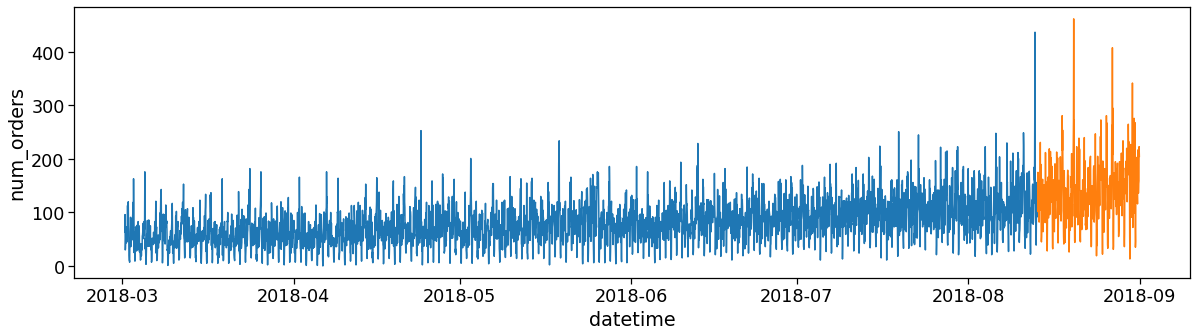

In [23]:
# creamos el gráfico de la distribución de los datos de entrenamiento y prueba

plt.figure(figsize = (20, 5))
sns.lineplot(features_train.index, target_train)
sns.lineplot(features_test.index, target_test)
plt.show()

### ARIMA

In [24]:
def rmse(y_actual, y_pred):
    
    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [25]:
# creamos el modelo ARIMA

y = target_train

ARIMAmodelo = ARIMA(y, order = (5, 0, 10))
ARIMAmodelo = ARIMAmodelo.fit()

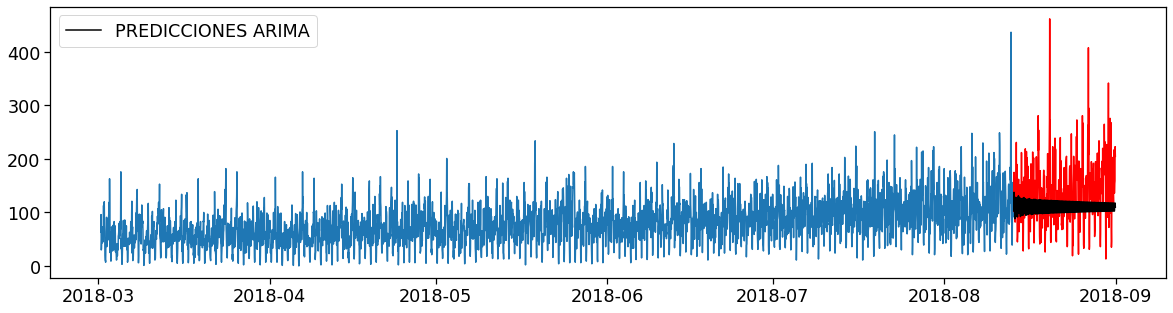

In [26]:
y_pred = ARIMAmodelo.get_forecast(len(target_test))

y_pred_df = y_pred.conf_int()
y_pred_df['prediccion'] = ARIMAmodelo.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = target_test.index
y_pred_out = y_pred_df['prediccion']

plt.figure(figsize = (20, 5))
plt.plot(target_train)
plt.plot(target_test, color = 'red')
plt.plot(y_pred_out, color = 'black', label = 'PREDICCIONES ARIMA')
plt.legend()
plt.show()

In [27]:
# Mostramos el RMSE de ARIMA

rmse(target_test, y_pred_out)

63.916933056245256

## Prueba

### Regresion Lineal

In [28]:
lineal_reg = LinearRegression()
lineal_reg.fit(features_train, target_train)

y_pred_train_lr = lineal_reg.predict(features_train)
y_pred_test_lr = lineal_reg.predict(features_test)

In [29]:
print('RMSE de Entrenamiento:', rmse(target_train, y_pred_train_lr))
print('RMSE de Prueba:', rmse(target_test, y_pred_test_lr))

RMSE de Entrenamiento: 30.49157375237362
RMSE de Prueba: 53.10022806364771


### Bosque Aleatorio

In [30]:
%%time

bosque = defaultdict(list)

for n in [1, 2, 4, 5, 10, 17, 20, 26, 30]:
    model = RandomForestRegressor(random_state = 42, max_depth = n, n_estimators = 100)
    model.fit(features_train, target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    bosque['max_depth'].append(n)
    bosque['train_rmse'].append(np.sqrt(mean_squared_error(target_train, pred_train)))
    bosque['test_rmse'].append(np.sqrt(mean_squared_error(target_test, pred_test)))
    
display(pd.DataFrame(bosque))

,max_depth,train_rmse,test_rmse
0,1,33.722611,74.000612
1,2,30.201922,68.428819
2,4,25.648989,57.940059
3,5,24.062795,55.451720
4,10,15.257934,47.281049
5,17,8.827360,45.750214
6,20,8.505859,45.702836
7,26,8.437636,46.042600
8,30,8.439656,46.267608


CPU times: user 14.2 s, sys: 701 ms, total: 14.9 s
Wall time: 14.9 s


### XGBoost

In [31]:
%%time

resultado = defaultdict(list)

for n in range(1, 11):
    model = xgb.XGBRegressor(objective = 'reg:squarederror', max_depth = n) 
    model.fit(features_train, target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    resultado['max_depth'].append(n)
    resultado['train_rmse'].append(np.sqrt(mean_squared_error(target_train, pred_train)))
    resultado['test_rmse'].append(np.sqrt(mean_squared_error(target_test, pred_test)))
    
display(pd.DataFrame(resultado))

,max_depth,train_rmse,test_rmse
0,1,24.569680,50.108797
1,2,20.598736,49.053816
2,3,17.581877,48.289363
3,4,14.535105,45.037670
4,5,10.824439,45.126398
5,6,7.050929,47.241706
6,7,4.074987,49.612434
7,8,2.270489,53.132183
8,9,0.989431,53.862239
9,10,0.309026,55.813108


CPU times: user 18.1 s, sys: 276 ms, total: 18.4 s
Wall time: 18.5 s


### LightGBM

In [32]:
%%time

resultado = defaultdict(list)

for n in [10, 20, 30, 50, 70, 100]:
    model = lgbm.LGBMRegressor(objective = 'rmse', num_leaves = n , max_depth = 10)
    model.fit(features_train, target_train)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    resultado['num_leaves'].append(n)
    resultado['train_rmse'].append(rmse(target_train, pred_train))
    resultado['test_rmse'].append(rmse(target_test, pred_test))
    
display(pd.DataFrame(resultado))

,num_leaves,train_rmse,test_rmse
0,10,19.447900,44.350819
1,20,16.894380,44.114176
2,30,15.201356,44.165117
3,50,13.536870,43.472545
4,70,12.933502,44.520137
5,100,12.288221,43.785144


CPU times: user 2.51 s, sys: 20.5 ms, total: 2.53 s
Wall time: 2.5 s


### CatBoost

In [33]:
%%time

resultado = defaultdict(list)

for n in range(1, 11):
    model = cb.CatBoostRegressor(loss_function = 'RMSE', depth = n, iterations = 150, random_seed =42)
    model.fit(features_train, target_train, verbose = False)
    
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    resultado['max_depth'].append(n)
    resultado['train_rmse'].append(rmse(target_train, pred_train))
    resultado['test_rmse'].append(rmse(target_test, pred_test))
    
display(pd.DataFrame(resultado))

,max_depth,train_rmse,test_rmse
0,1,24.579963,50.807173
1,2,21.215863,47.526362
2,3,19.383648,47.843906
3,4,17.862334,42.986758
4,5,16.632264,42.574434
5,6,15.042500,43.854223
6,7,13.589860,49.262132
7,8,11.406639,47.290737
8,9,10.040610,46.638845
9,10,7.627698,48.889379


CPU times: user 8.58 s, sys: 356 ms, total: 8.93 s
Wall time: 9.91 s


### Visualización del Mejor Modelo


In [34]:
# entrenamos el mejor modelo en catboost

catboost = cb.CatBoostRegressor(loss_function = 'RMSE', depth = 5, iterations = 150, random_seed = 42)
catboost.fit(features_train, target_train, verbose = False)

pred_train_cb = catboost.predict(features_train)
pred_test_cb = catboost.predict(features_test)

cb_pred = pd.DataFrame(pred_test_cb)
cb_pred.index = target_test.index

rmse(target_train, pred_train_cb), rmse(target_test, pred_test_cb)

(16.632264179583565, 42.57443350106846)

In [35]:
# creamos el nuevo conjunto de datos para la predicción del catboost

result_cb = pd.concat([target_test, cb_pred], axis = 1).reindex(target_test.index)
result_cb.head()

,num_orders,0
datetime,,
2018-08-13 14:00:00,102,92.334261
2018-08-13 15:00:00,175,109.706877
2018-08-13 16:00:00,144,155.921958
2018-08-13 17:00:00,152,125.540127
2018-08-13 18:00:00,104,109.937727


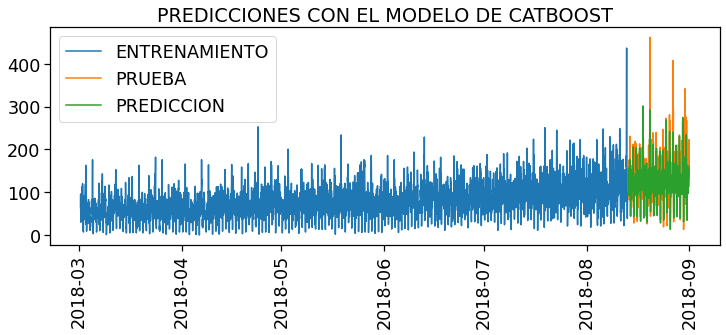

In [36]:
# graficamos las predicciones catboost

plt.figure(figsize = (12, 4))
plt.plot(target_train.index, target_train, label = 'ENTRENAMIENTO')
plt.plot(target_test.index, target_test, label = 'PRUEBA')
plt.plot(result_cb.index, result_cb[0], label ='PREDICCION')
plt.xticks(rotation = 'vertical')
plt.legend(loc = 'best')
plt.title('PREDICCIONES CON EL MODELO DE CATBOOST')
plt.show()

## Conclusiones

**1. Preparación de datos**

* El conjunto de datos nos mostró unas columnas con varios tiempos y un número de reservas de taxis desde el aeropuerto.

* No se encontraron valores ausentes ni duplicados.

* Se realizaron cambios en la columna de 'datetime' para efectos de trabajar mejor.

**2. Análisis**

* Se pudo observar que las reservas de taxis aumentan cada mes, pero no mucho los primeros meses.

* Se remuestro la primera semana de marzo y los dos primeros días de agosto, esto para poder ver la distribución de los datos enfocados en la estacionalidad.

* El punto máximo de reservas de taxis desde el aeropuerto es a las 00:00 o 12 pm, se supone que es porque a esa hora es el unico medio de transporte.

* A las 6 am es la hora con menos reservas de taxis, se supone que a esa hora estan comenzando los vuelos y que no hay muchos aterrizajes.

**3. Formación**

* Se le anexaron unas 5 columnas de rezago y una ventana movil de 10 con un valor promedio.

* Se aplico el modelo ARIMA, donde produjo un valor RMSE alto y supera los umbrales puestos. Se estableció que el modelo aplicado a futuro deberia producir un valor RMSE mas bajo que el modelo ARIMA.

**4. Prueba**

* Entre los varios modelos de entrenamientos que se realizaron, se determinó que el mejor modelo es CatBoost con un parametro de max_depth igual a 5. En los resultados de prueba, este es el que tiene el valor más bajo de RMSE, aunque tiene una diferencia considerable con los datos de entrenamiento.



# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48